In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
import statsmodels.formula.api as smf
from sqlalchemy import create_engine

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

In [3]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
                       
weatherinszeged_df = pd.read_sql_query('select * from weatherinszeged',con=engine)

engine.dispose()

In [18]:
weatherinszeged_df.describe()

,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure
count,96453.000,96453.000,96453.000,96453.000,96453.000,96453.000,96453.000,96453.000
mean,11.933,10.855,0.735,10.811,187.509,10.347,0.000,1003.236
std,9.552,10.697,0.195,6.914,107.383,4.192,0.000,116.970
min,-21.822,-27.717,0.000,0.000,0.000,0.000,0.000,0.000
25%,4.689,2.311,0.600,5.828,116.000,8.340,0.000,1011.900
50%,12.000,12.000,0.780,9.966,180.000,10.046,0.000,1016.450
75%,18.839,18.839,0.890,14.136,290.000,14.812,0.000,1021.090
max,39.906,39.344,1.000,63.853,359.000,16.100,0.000,1046.380


In [4]:
#target variable is temperature
#feature variables are humidity, windspeed, windbearing, and pressure
print(weatherinszeged_df.head())

                       date        summary preciptype  temperature  \
0 2006-03-31 22:00:00+00:00  Partly Cloudy       rain        9.472   
1 2006-03-31 23:00:00+00:00  Partly Cloudy       rain        9.356   
2 2006-04-01 00:00:00+00:00  Mostly Cloudy       rain        9.378   
3 2006-04-01 01:00:00+00:00  Partly Cloudy       rain        8.289   
4 2006-04-01 02:00:00+00:00  Mostly Cloudy       rain        8.756   

   apparenttemperature  humidity  windspeed  windbearing  visibility  \
0                7.389     0.890     14.120      251.000      15.826   
1                7.228     0.860     14.265      259.000      15.826   
2                9.378     0.890      3.928      204.000      14.957   
3                5.944     0.830     14.104      269.000      15.826   
4                6.978     0.830     11.045      259.000      15.826   

   loudcover  pressure                       dailysummary  
0      0.000  1015.130  Partly cloudy throughout the day.  
1      0.000  1015.630  Pa

In [19]:
weatherinszeged_df.isnull().sum()

date                   0
summary                0
preciptype             0
temperature            0
apparenttemperature    0
humidity               0
windspeed              0
windbearing            0
visibility             0
loudcover              0
pressure               0
dailysummary           0
dtype: int64

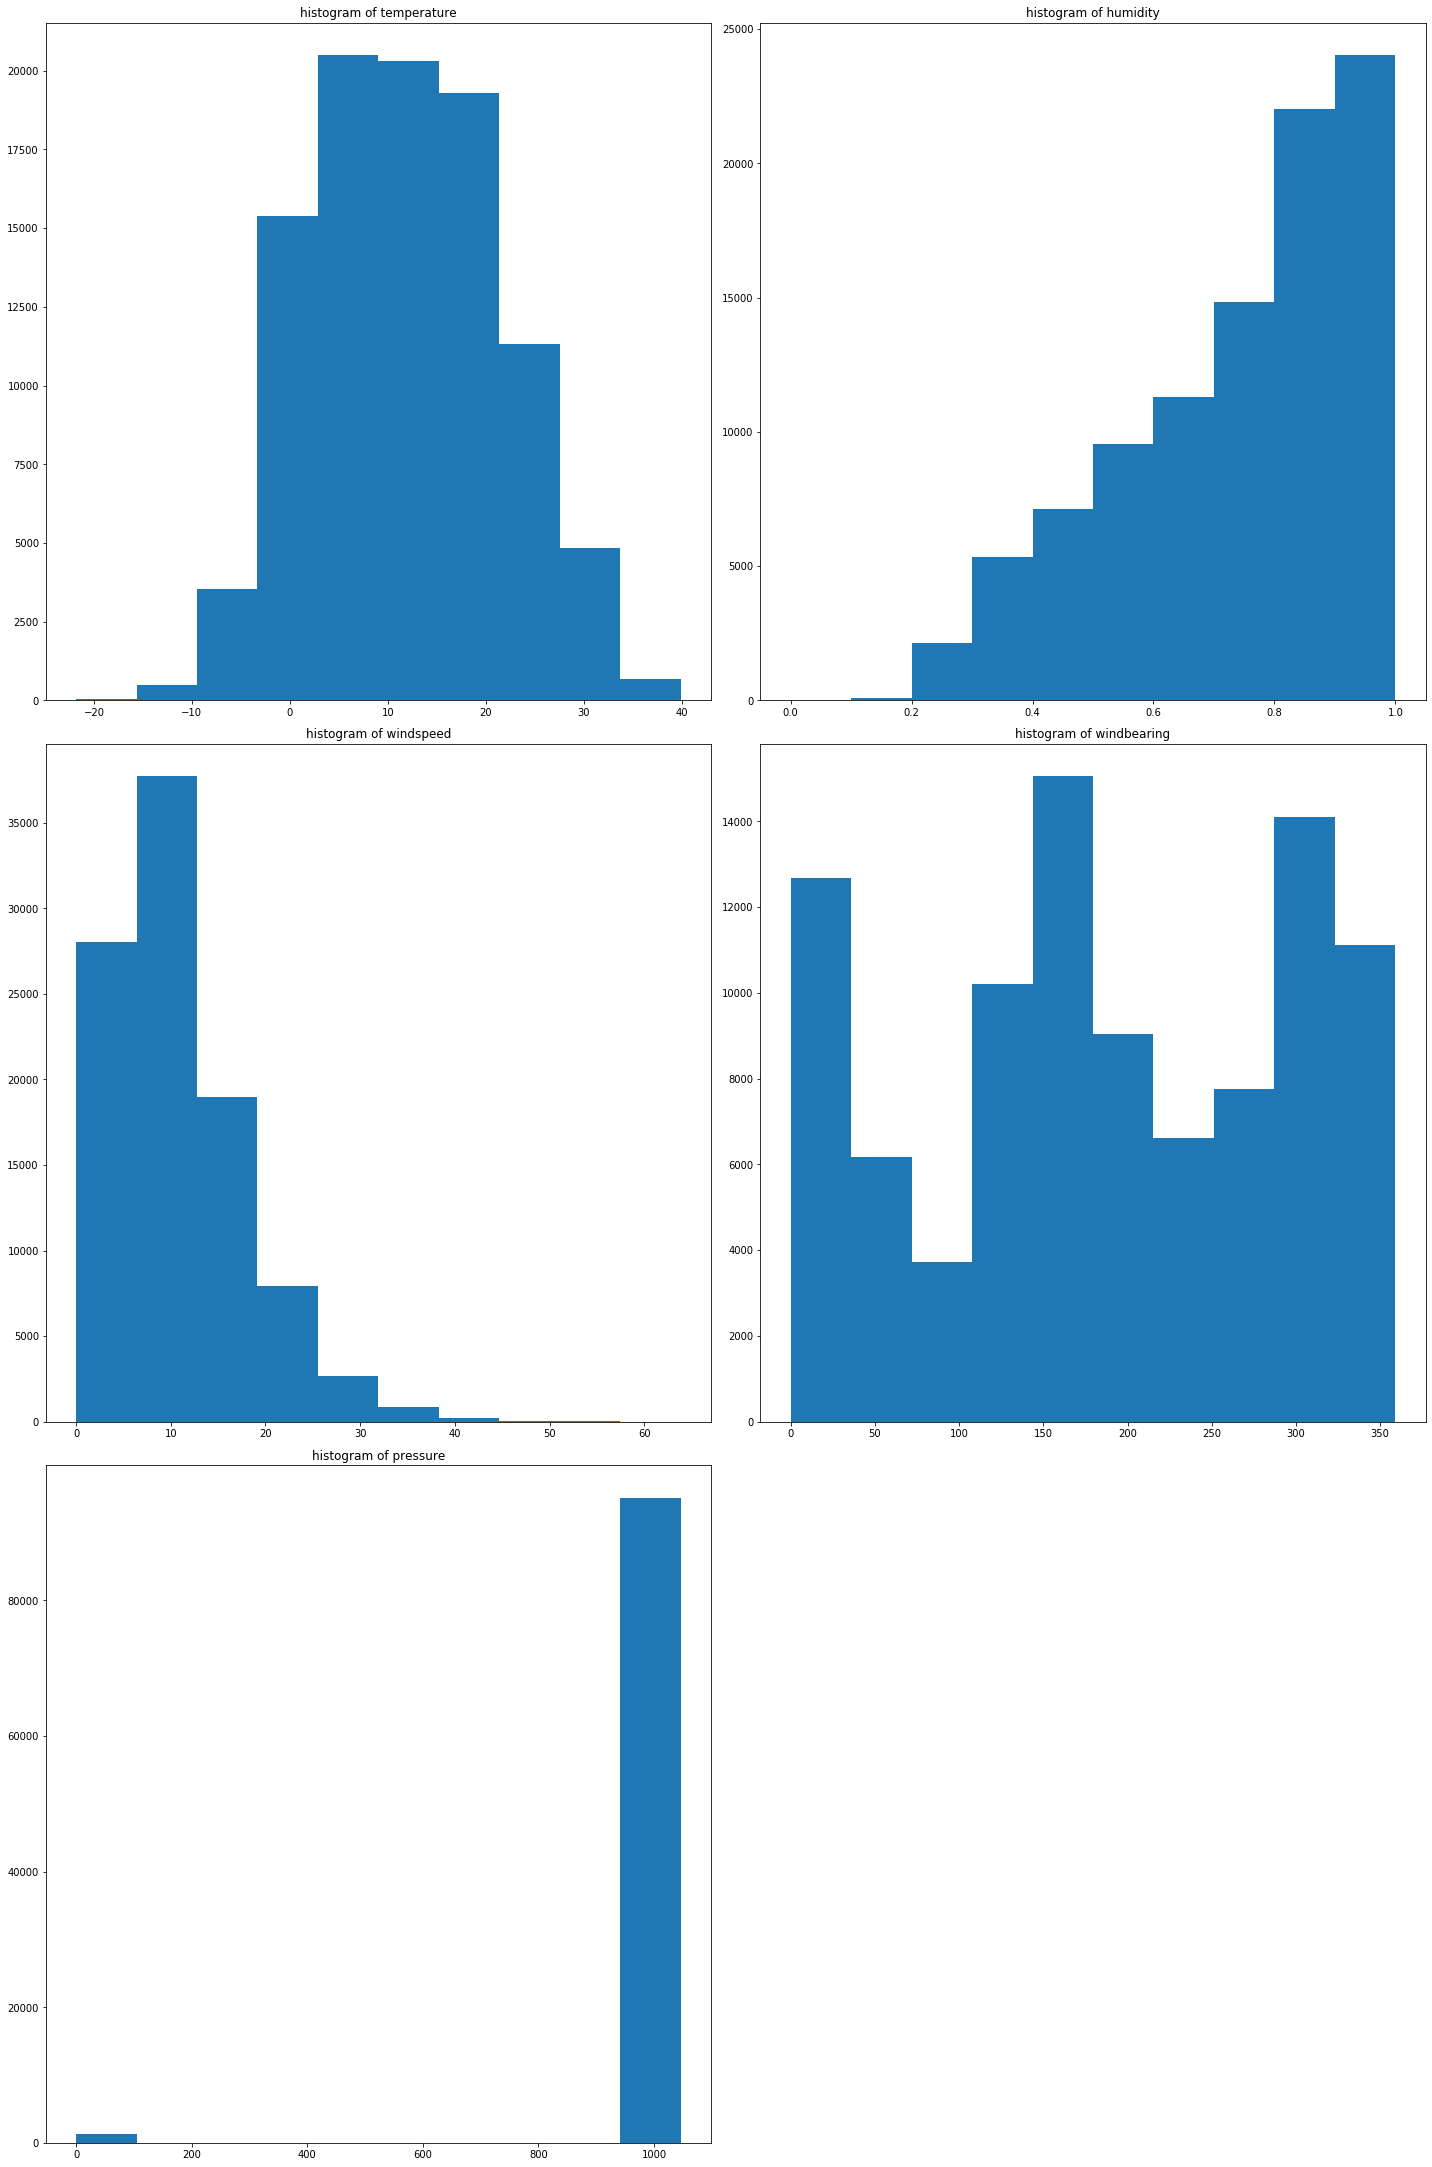

In [39]:
variables = ['temperature', 'humidity', 'windspeed', 'windbearing', 'pressure']
plt.figure(figsize=(20,50))
for i, var in enumerate(variables):
    
    plt.subplot(len(variables), 2, i+1)
    plt.hist(weatherinszeged_df[var])
    plt.title('histogram of {}'.format(var))

plt.tight_layout()

Only temperature has a somewhat normal distribution

In [6]:
Y = weatherinszeged_df['temperature']

X = weatherinszeged_df[['humidity', 'windspeed', 'windbearing', 'pressure']]

X_sqr = X**2
# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [-3.24962454e+01 -2.01413742e-01  4.04836936e-03 -6.91759209e-04]

Intercept: 
 37.92643818528537


In [29]:
lrm.fit(X,Y)
predictions = lrm.predict(X)
# we print the estimated coefficients
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)

errors = Y - predictions
print("Mean of the errors in the medical costs model is: {}".format(np.mean(errors)))


Coefficients: 
 [-3.24962454e+01 -2.01413742e-01  4.04836936e-03 -6.91759209e-04]

Intercept: 
 37.92643818528537
Mean of the errors in the medical costs model is: -1.9624955657832385e-15


the error term is basically zero in our model which is what we needed.

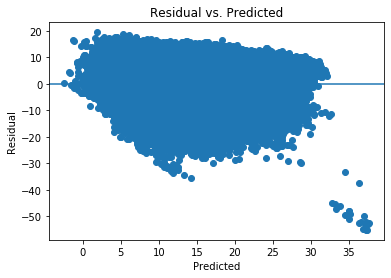

In [30]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [31]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 2464.84 and p value is 0
Levene test statistic value is 2321.24 and p value is 0


Our means are heteroscedastic instead of homoscedastic. I will check the distributions of our variables to check.

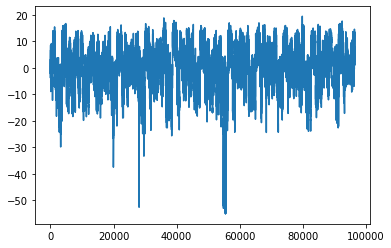

In [32]:
plt.plot(errors)

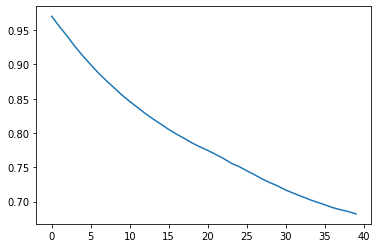

In [33]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

This shows that some of our error terms have high correlation which is a problem

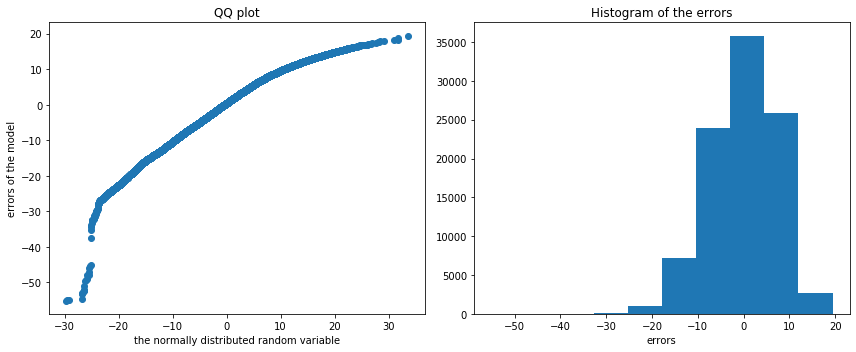

In [40]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

In [35]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest
jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 3793.296735252356 and p value is 0.0
Normality test statistics is 3375.4323076995797 and p value is 0.0


Visually our  errors are relatively close to normal but after running the Jarque-Bera and Normality tests we can see that they most certainly aren't